# IMPORT DATASET

In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
calorie = pd.read_csv("train.csv")
test_original = pd.read_csv('test.csv')

# DATA VISUALIZATION

Let's preview the dataset:

In [82]:
calorie.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          750000 non-null  int64  
 1   Sex         750000 non-null  object 
 2   Age         750000 non-null  int64  
 3   Height      750000 non-null  float64
 4   Weight      750000 non-null  float64
 5   Duration    750000 non-null  float64
 6   Heart_Rate  750000 non-null  float64
 7   Body_Temp   750000 non-null  float64
 8   Calories    750000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 51.5+ MB


In [83]:
calorie.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [84]:
calorie.describe()

,id,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,41.420404,174.697685,75.145668,15.421015,95.483995,40.036253,88.282781
std,216506.495284,15.175049,12.824496,13.982704,8.354095,9.449845,0.779875,62.395349
min,0.000000,20.000000,126.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,187499.750000,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,34.000000
50%,374999.500000,40.000000,174.000000,74.000000,15.000000,95.000000,40.300000,77.000000
75%,562499.250000,52.000000,185.000000,87.000000,23.000000,103.000000,40.700000,136.000000
max,749999.000000,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


All seems great! There is no missing data here, and most the data is numerical, which make the process easier.

Let's see the distribution of some variable like: Age, Height, Weight, Heart_Rate, Body_Temp and Duration (duration of a workout).

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

calorie.hist(bins = 50, figsize = (20, 17))

array([[<Axes: title={'center': 'id'}>, <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Height'}>],
       [<Axes: title={'center': 'Weight'}>,
        <Axes: title={'center': 'Duration'}>,
        <Axes: title={'center': 'Heart_Rate'}>],
       [<Axes: title={'center': 'Body_Temp'}>,
        <Axes: title={'center': 'Calories'}>, <Axes: >]], dtype=object)

All seems good:
- Age: A large portion is around 20 years old and somewhat right-skewed, maybe because most of them doesn't have a job yet so the time they have is more than others.
- Height varies, but most likely is the joint combination of height distribution between male and female.
- Weight is slightly right skewed.
- Duration is nearly uniform.
- Heart Rate is close to normal distribution.
- Body Temp increase and stable as you exercise.
- Calories decrease as harder workout burn more calories - very right skewed.

# SPLIT TRAIN DATA AND LABELS

In [86]:
train_data = calorie.drop(['id', 'Calories'], axis = 1)
test_data = test_original.drop('id', axis = 1)

In [87]:
train_labels = calorie['Calories']

# DATA INVESTIGATION AND PREPARATION

## Investigate relationship between variables

Let's investigate to see which variable has the most impact on "Calories".

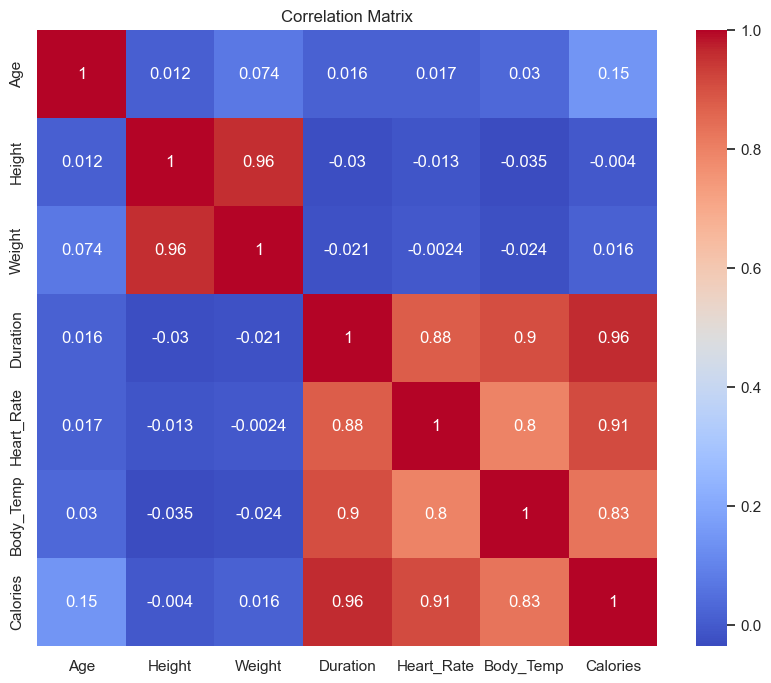

In [128]:
calorie_numerical_only = calorie.drop(['id', 'Sex'], axis = 1)
plt.figure(figsize=(10,8))
sns.heatmap(calorie_numerical_only.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [89]:
corr_matrix = calorie_numerical_only.corr()

corr_matrix["Calories"].sort_values(ascending = False)

Calories      1.000000
Duration      0.959908
Heart_Rate    0.908748
Body_Temp     0.828671
Age           0.145683
Weight        0.015863
Height       -0.004026
Name: Calories, dtype: float64

Conclusion: Duration, Heart_Rate and Body_Temp are the most correlated feature here.

## Exploratory Data Analysis

Let's turn back to our correlation matrix:

In [90]:
train_eda = calorie.copy()

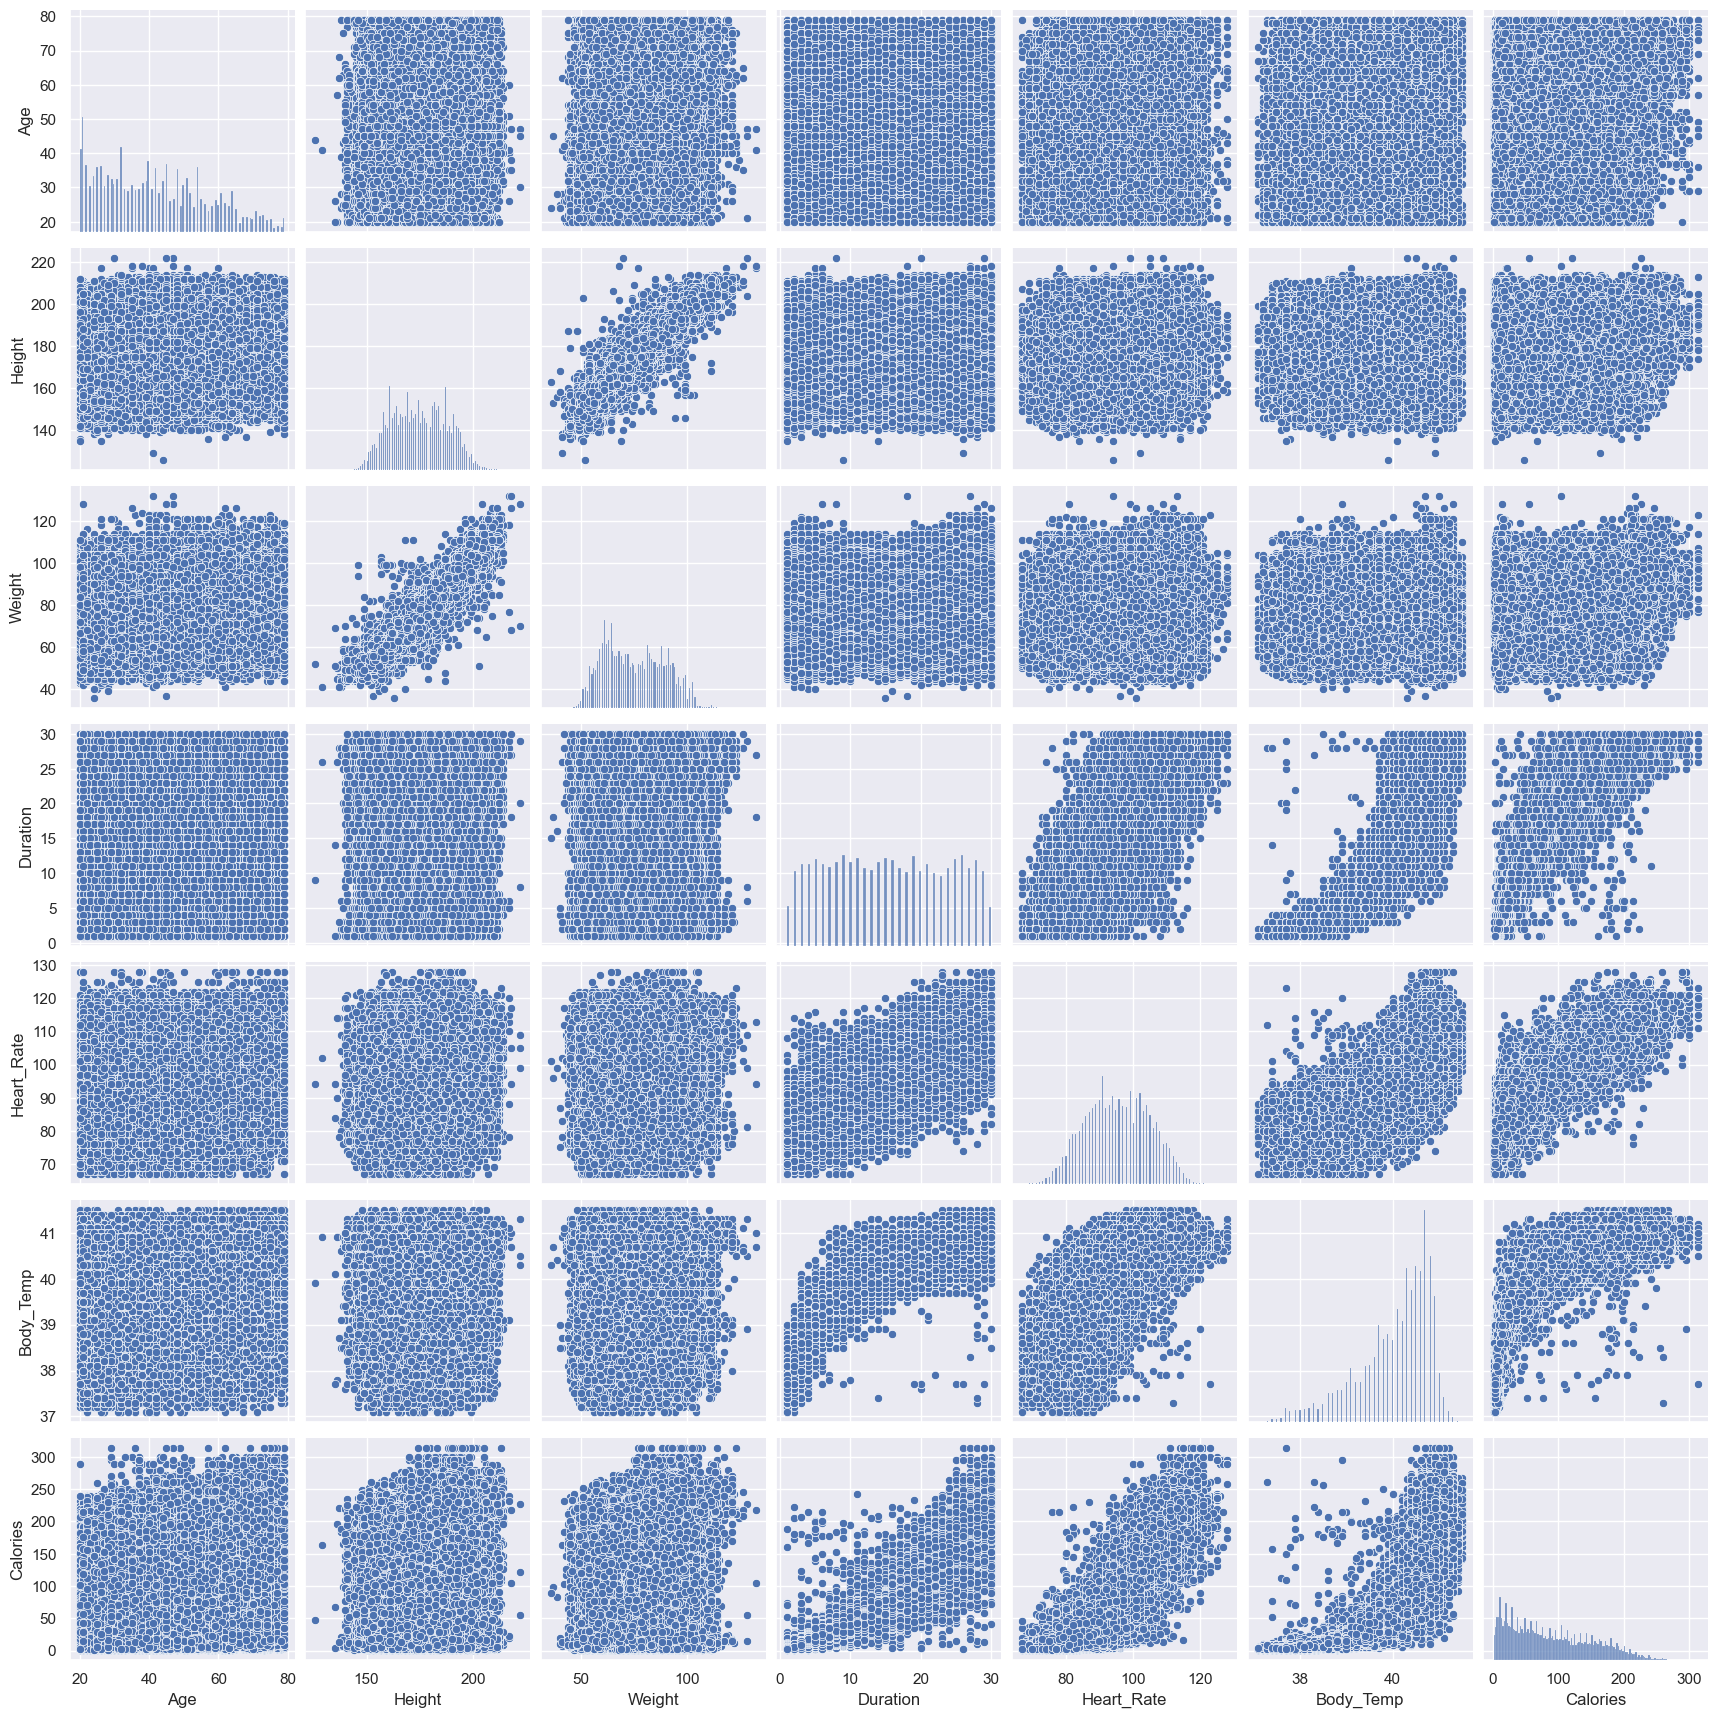

In [91]:
sns.pairplot(train_eda[['Age', "Height", 'Weight', 'Duration', 'Heart_Rate', "Body_Temp", 'Calories']])
plt.show()

We can see that calories may have a non-linear relationship with body_temp and likely linear with duration and heart_rate.

Let's see if the log-transformation can turn the relationship between Body_Temp and Calories into a linear relationship:

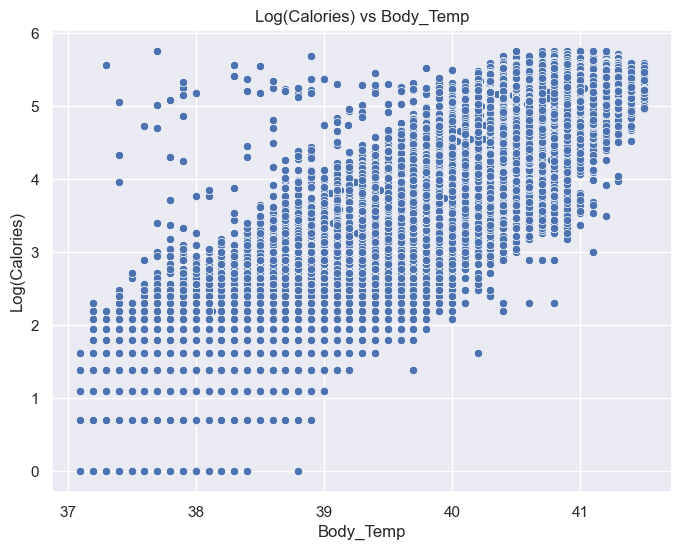

In [92]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create a new column for log(Calories)
train_eda['Log_Calories'] = np.log(train_eda['Calories'])

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Body_Temp', y='Log_Calories', data=train_eda)
plt.title('Log(Calories) vs Body_Temp')
plt.xlabel('Body_Temp')
plt.ylabel('Log(Calories)')
plt.show()

We can see this is likely to be linear. Let's build a simple linear model to test our hypothesis:

In [93]:
import statsmodels.api as sm
#Create a linear model
X = train_eda['Body_Temp']
y = train_eda['Log_Calories']

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           Log_Calories   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.909
Method:                 Least Squares   F-statistic:                 7.461e+06
Date:                Fri, 23 May 2025   Prob (F-statistic):               0.00
Time:                        20:52:18   Log-Likelihood:            -1.6911e+05
No. Observations:              750000   AIC:                         3.382e+05
Df Residuals:                  749998   BIC:                         3.383e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -44.9765      0.018  -2502.157      0.0

We achieve the model:

Calories = 2.92×10^-20 * e ^(1.2261 * Body_Temp)

With p-value of both coefficient p ~ 0.000, which is significant for us to conclude that there is a exponential relationship between these two variable.

Conclusion: Every 1°C increase in body temperature increases calorie burn by about 3.41 times.

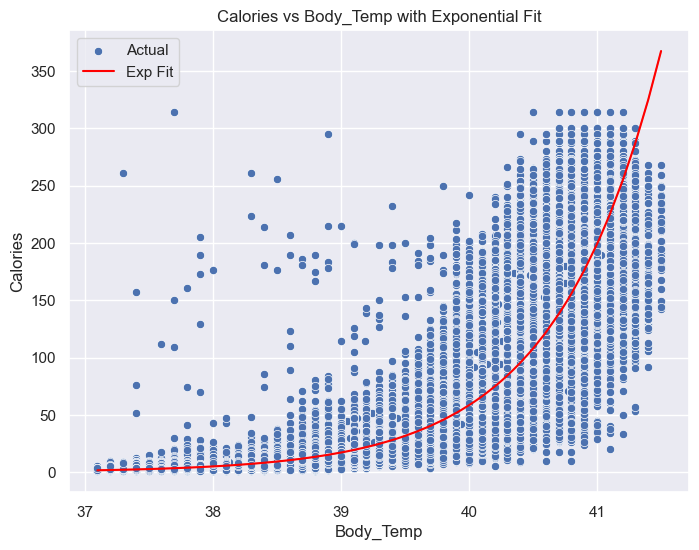

In [94]:
# Get fitted values for Calories
train_eda['Exp_Fit'] = np.exp(model.predict(X))

# Plot actual Calories and exponential fit
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Body_Temp', y='Calories', data=train_eda, label='Actual')
sns.lineplot(x='Body_Temp', y='Exp_Fit', data=train_eda, color='red', label='Exp Fit')
plt.title('Calories vs Body_Temp with Exponential Fit')
plt.xlabel('Body_Temp')
plt.ylabel('Calories')
plt.legend()
plt.show()

We can once again confirm our conclusion by plotting the scatterplot along with the exponential line.

Let's see the histogram and boxplot of each variable:

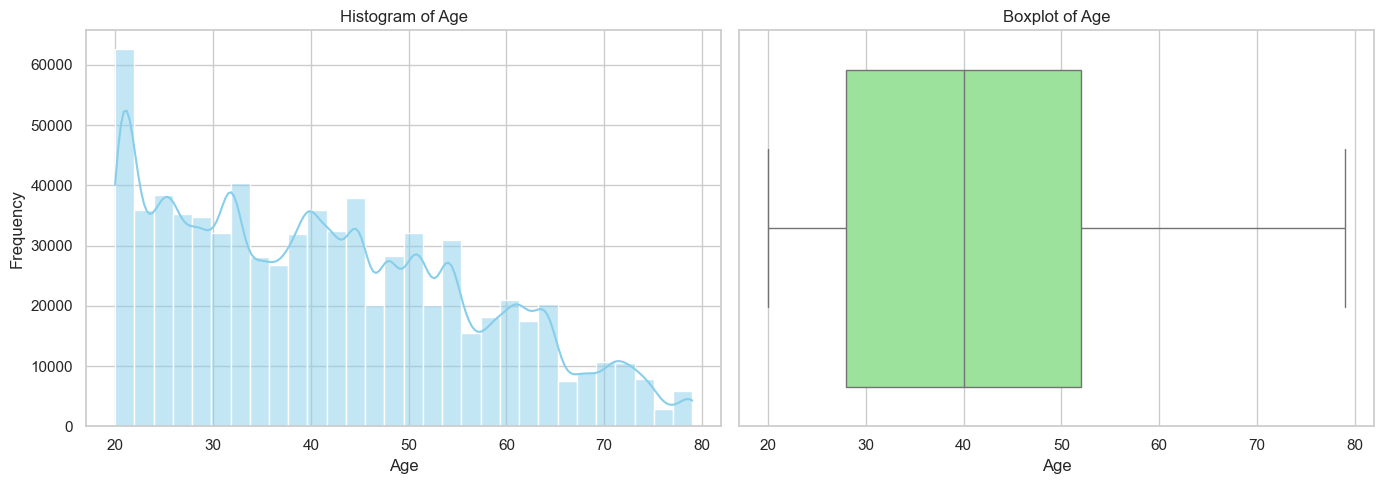

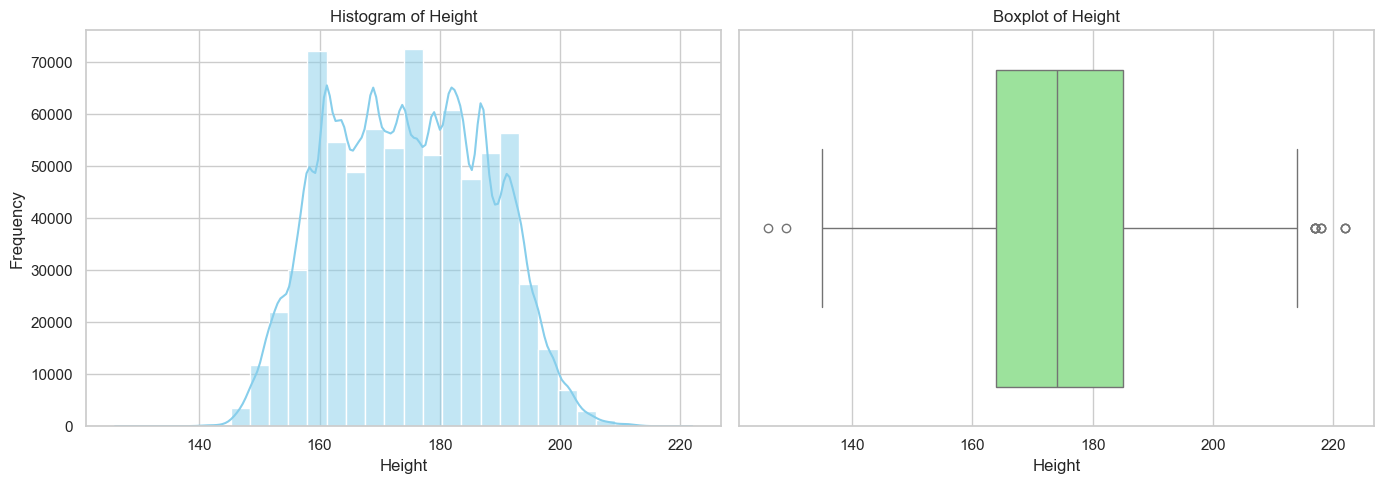

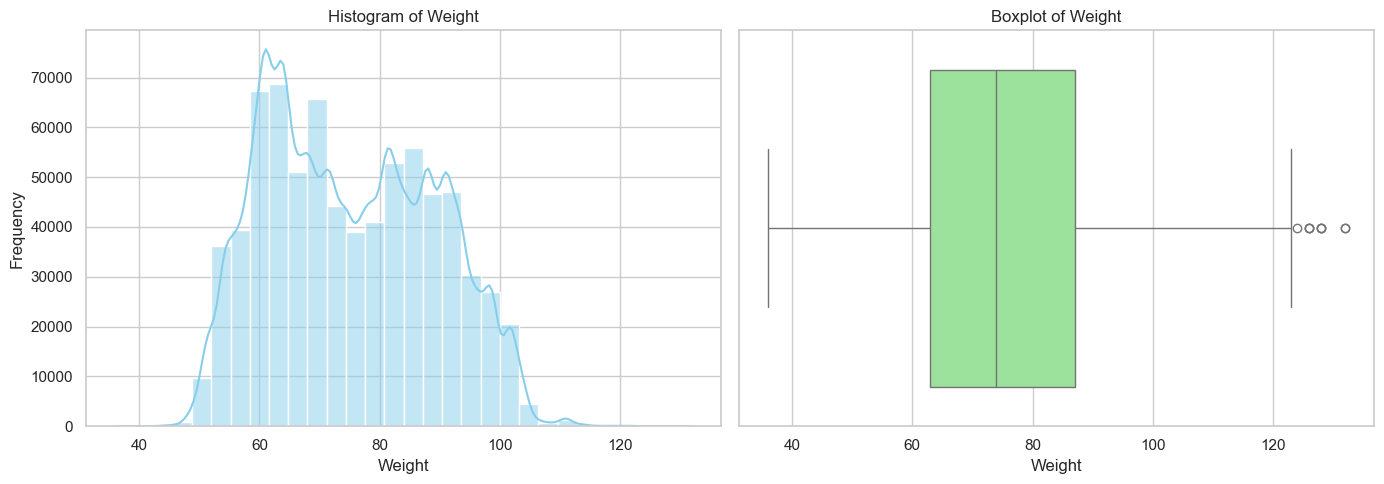

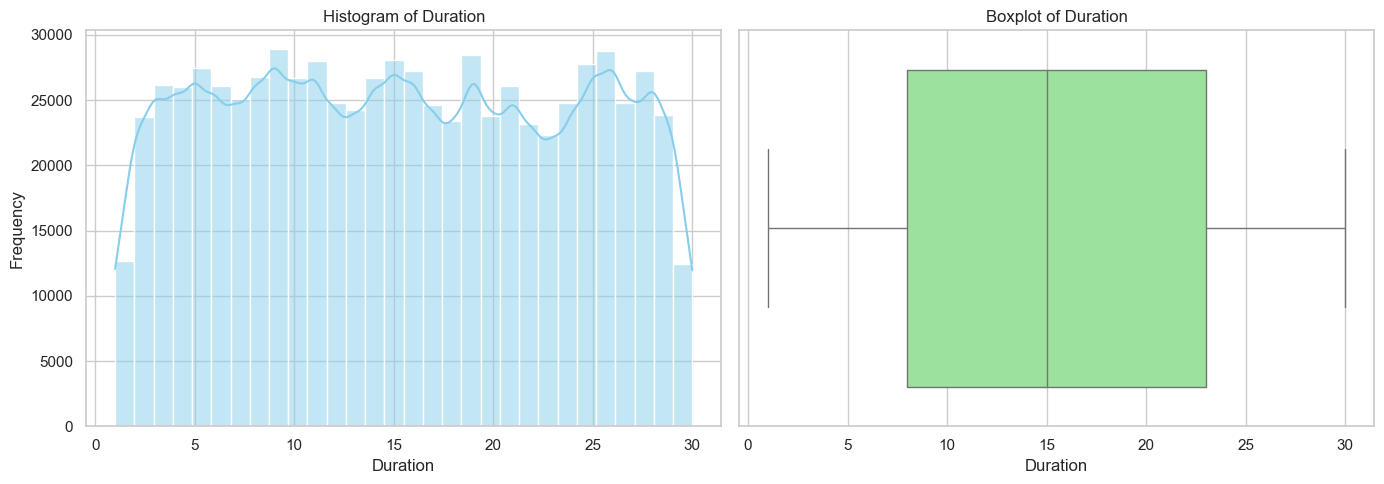

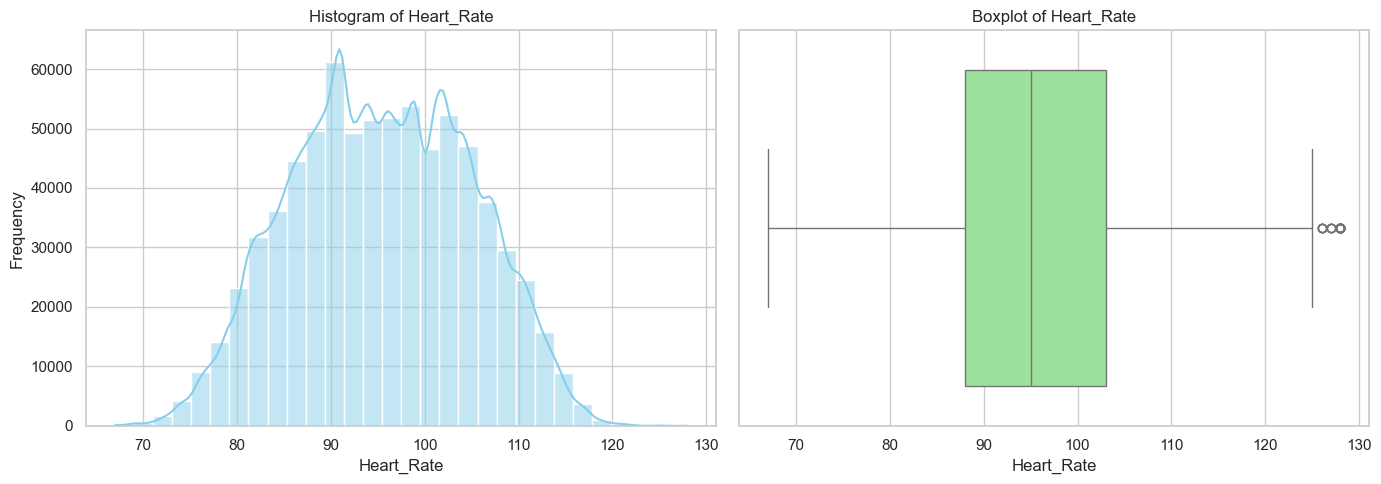

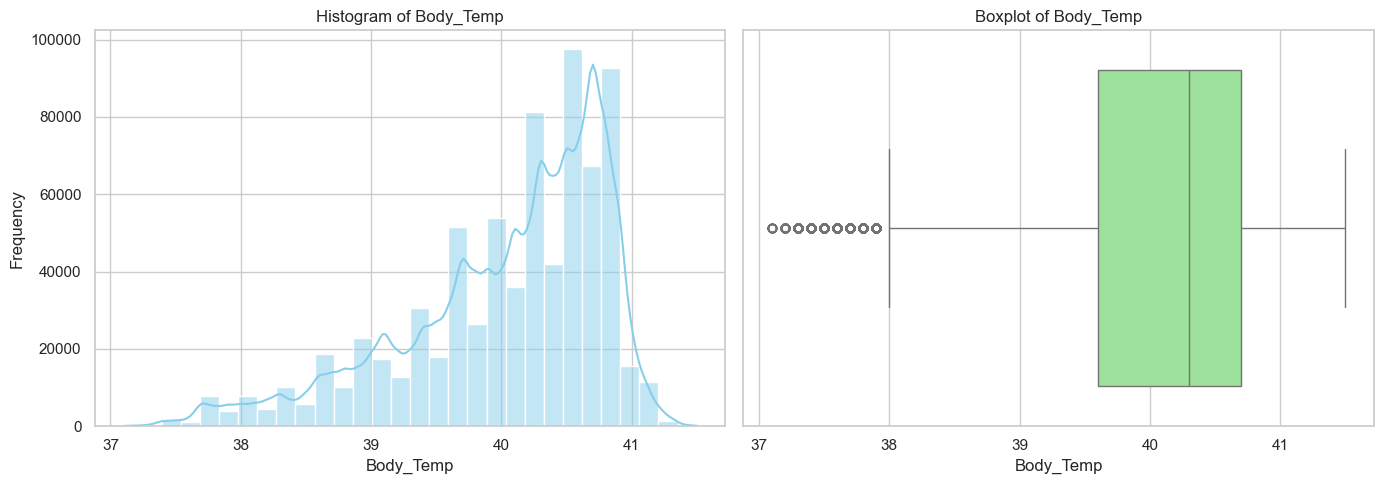

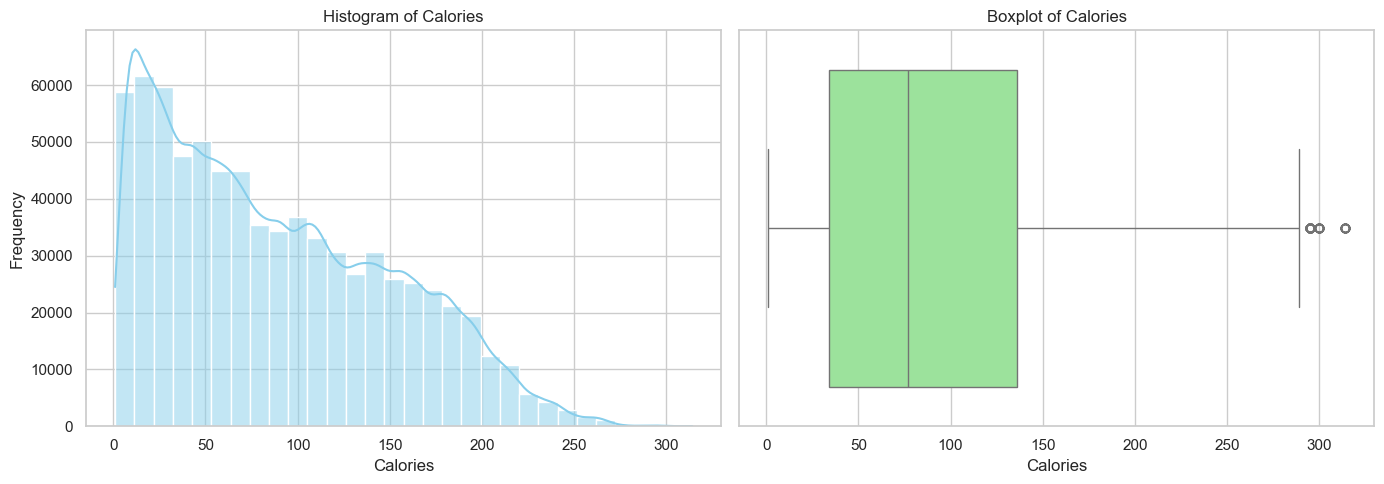

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of columns to visualize
columns = ['Age', 'Height', 'Weight', 'Duration', 'Heart_Rate', 'Body_Temp', 'Calories']

# Set the style
sns.set(style="whitegrid")

# Plot histograms and boxplots
for col in columns:
    plt.figure(figsize=(14, 5))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(train_eda[col], kde=True, bins=30, color='skyblue')
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(x=train_eda[col], color='lightgreen')
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)

    plt.tight_layout()
    plt.show()


- Age: Log transformation
- Height: Do nothing
- Weight: Log transformation
- Duration: Do nothing / create a new variable for bin duration (e.g < 5 mins, 5-10 mins, etc)
- Heart_Rate: Do nothing
- Body_Temp: Do nothing (Standardize)

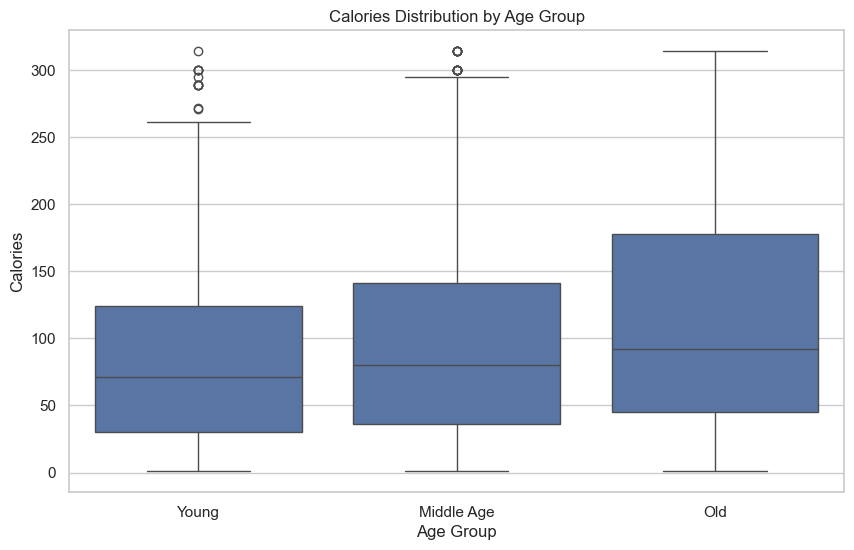

In [96]:
import seaborn as sns

age_bins = [20, 35, 65, 80]
age_labels = ['Young', 'Middle Age', 'Old']

train_eda['Age_Grp'] = pd.cut(train_eda['Age'], bins=age_bins, labels=age_labels, right=True, include_lowest=True)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Age_Grp', y='Calories', data=train_eda)
plt.title('Calories Distribution by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Calories')
plt.show()

This suggest the like of the more you get old, the more calories you burn.

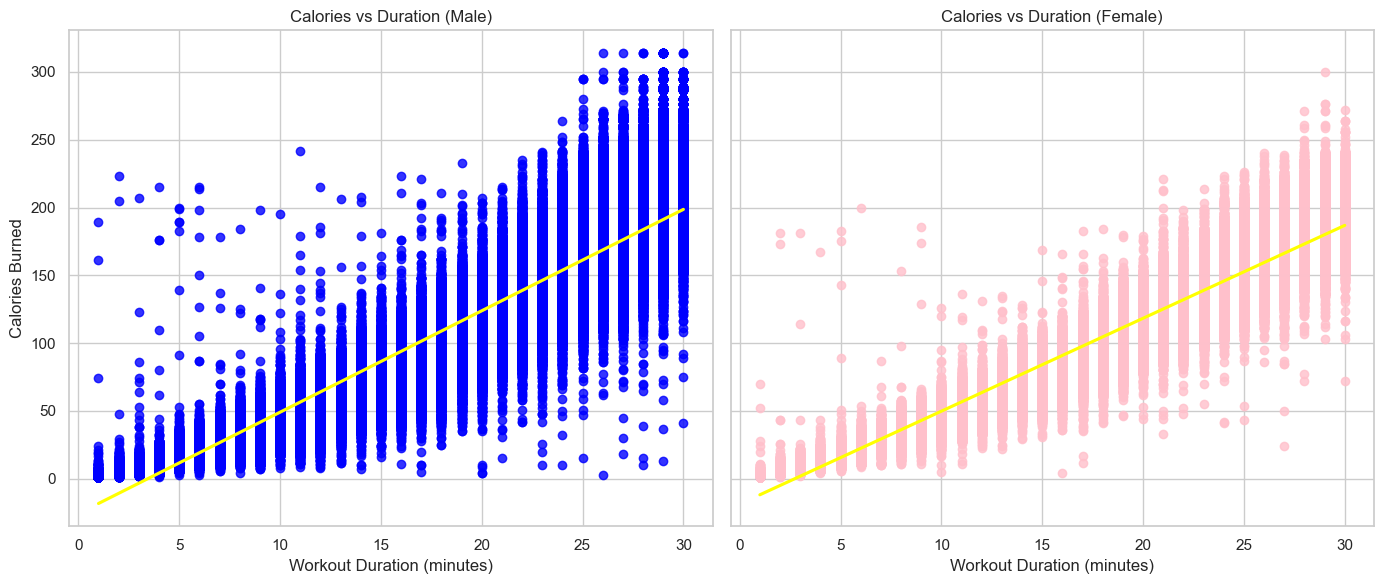

In [97]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Male plot with regression line
male_data = calorie[calorie['Sex'] == 'male']
sns.regplot(x='Duration', y='Calories', data=male_data, ax=axes[0],
           scatter_kws={'color': 'blue'}, line_kws={'color': 'yellow'})
axes[0].set_title('Calories vs Duration (Male)')
axes[0].set_xlabel('Workout Duration (minutes)')
axes[0].set_ylabel('Calories Burned')

# Female plot with regression line
female_data = calorie[calorie['Sex'] == 'female']
sns.regplot(x='Duration', y='Calories', data=female_data, ax=axes[1],
           scatter_kws={'color': 'pink'}, line_kws={'color': 'yellow'})
axes[1].set_title('Calories vs Duration (Female)')
axes[1].set_xlabel('Workout Duration (minutes)')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

From this graph, we can see that both duration and calories burned of men have higher range compared to that of women.

## Create new variables
Let's try to create some new variable that may be useful:
- BMI (Body Mass Index) = Weight / (Height ** 2) (Weight in kg, Height in m)
- Interactive terms: Weight * Duration
- Interactive terms: Duration * Body_Temp

In [98]:
from sklearn.base import BaseEstimator, TransformerMixin

class AttributeAdder(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None):
        return self
    def transform(self, X, y= None):

        if hasattr(X, 'loc'):
            BMI = X['Weight'] / ((X['Height'] / 100) ** 2)
            duration_weight = X['Duration'] * X['Weight']
            duration_bodytemp = X['Duration'] * X["Body_Temp"]
            X = X.copy()
            X['BMI'] = BMI
            X['Duration_Weight'] = duration_weight
            X['Duration_Bodytemp'] = duration_bodytemp
            return X
        else:
            print("Error please check that input is DataFrame!")

This code allow us to calculate new variable BMI and Weight \* Duration.

Let's try and see how the BMI and duration_weight distributed.

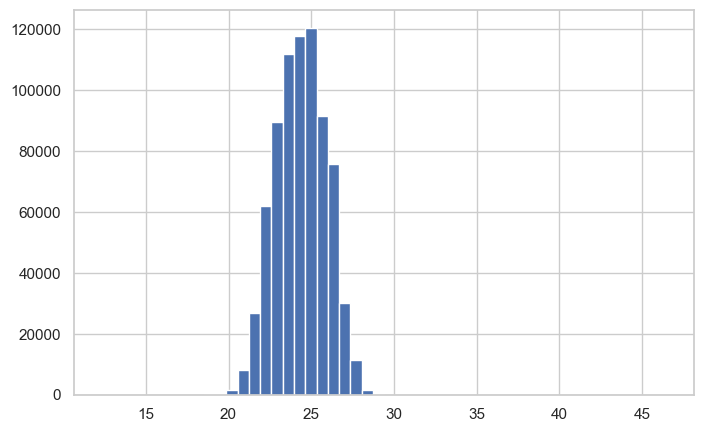

In [99]:
adder = AttributeAdder()
train_ver1 = adder.transform(calorie)
train_ver1['BMI'].hist(bins=50, figsize=(8, 5))
plt.show()

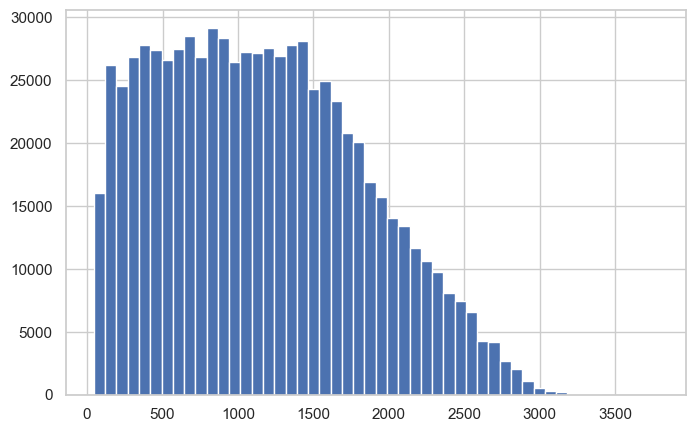

In [100]:
train_ver1["Duration_Weight"].hist(bins = 50, figsize = (8, 5))
plt.show()

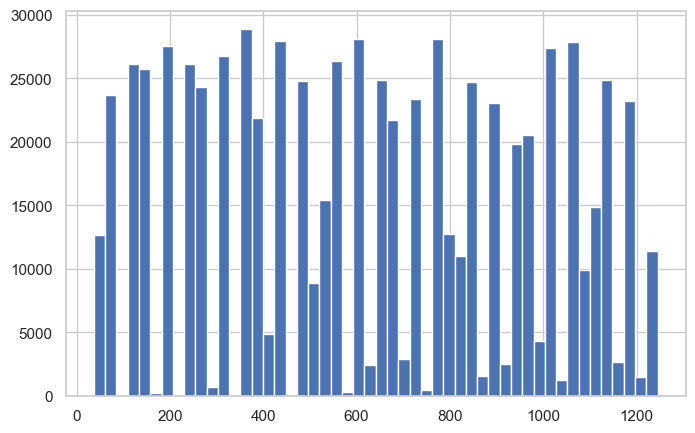

In [101]:
train_ver1['Duration_Bodytemp'].hist(bins = 50, figsize=(8,5))
plt.show()

In [102]:
train_ver1_numerical_only = train_ver1.drop(['id', 'Sex'], axis = 1)
corr_matrix = train_ver1_numerical_only.corr()

corr_matrix['Calories'].sort_values(ascending=False)

Calories             1.000000
Duration_Bodytemp    0.960909
Duration             0.959908
Duration_Weight      0.912617
Heart_Rate           0.908748
Body_Temp            0.828671
Age                  0.145683
BMI                  0.049226
Weight               0.015863
Height              -0.004026
Name: Calories, dtype: float64

Looks like BMI doesn't have significant linear correlation with Calories while Duration_Weight is just behind Duration.

The star of today show is Duration_BodyTemp - even better than Duration alone!!

Let's see the relationship between Duration_BodyTemp and calories

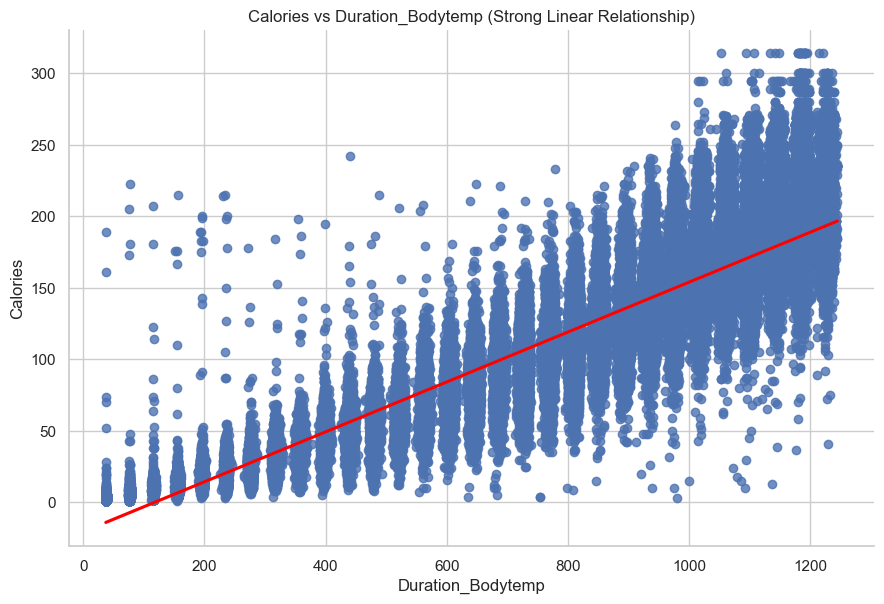

In [103]:
sns.lmplot(
    x='Duration_Bodytemp',
    y='Calories',
    data=train_ver1,
    height=6,
    aspect=1.5,
    line_kws={'color': 'red'}  # Customize line color here
)
plt.title('Calories vs Duration_Bodytemp (Strong Linear Relationship)')
plt.show()

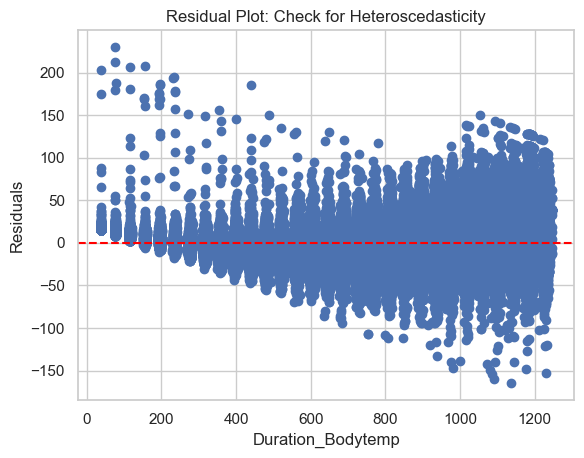

In [104]:
import matplotlib.pyplot as plt
import statsmodels.api as sm

X = sm.add_constant(train_ver1['Duration_Bodytemp'])
y = train_ver1['Calories']

model = sm.OLS(y, X).fit()
residuals = model.resid

plt.scatter(train_ver1['Duration_Bodytemp'], residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Duration_Bodytemp')
plt.ylabel('Residuals')
plt.title('Residual Plot: Check for Heteroscedasticity')
plt.show()


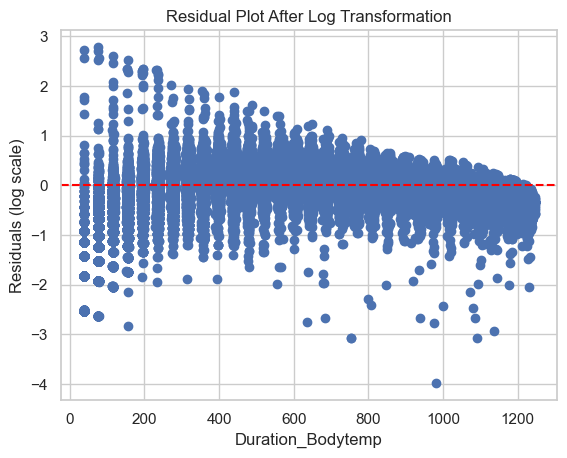

In [105]:
y_log = np.log(train_ver1['Calories'])

model_log = sm.OLS(y_log, X).fit()
residuals_log = model_log.resid

plt.scatter(train_ver1['Duration_Bodytemp'], residuals_log)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Duration_Bodytemp')
plt.ylabel('Residuals (log scale)')
plt.title('Residual Plot After Log Transformation')
plt.show()

So, it suggest that it's maybe better to convert calories into log(calories) and inverse transform to yield the results.

## Transform variable & Create pipeline

We will perform actions based on each variable:
- Sex: OneHotEncoder, to encode "male" as 0 and "female" as 1.
- Age: Log transformation
- Height: Do nothing
- Weight: Log transformation
- Duration: Do nothing / create a new variable for bin duration (e.g < 5 mins, 5-10 mins, etc)
- Heart_Rate: Do nothing
- Body_Temp: Do nothing (Standardize)
- BMI: Do nothing
- Duration_Weight: Log-Transformation
- Duration_BodyTemp: Standardize (Because it correlated strongly with log(calories))

In [106]:
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion

class CreateDurationBins(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.bins = [0, 5, 10, 15, 20, 25, 30, np.inf]
        self.binsLabel = [
            '0-5 mins', '5-10 mins', '10-15 mins', '15-20 mins',
            '20-25 mins', '25-30 mins', '>30 mins'
        ]

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        X_1 = X.copy()
        duration_values = X.iloc[:, 0]

        binned = pd.cut(duration_values, bins = self.bins, labels=self.binsLabel, right=False)
        X_1["Duration_Binned"] = binned
        return X_1

### THIS CODE CREATE DURATION BINS

We'll create the total pipeline:

In [107]:
log_transformer = FunctionTransformer(np.log1p, validate = False)

main_transformer = ColumnTransformer(transformers=[
    ('sex', OneHotEncoder(drop='if_binary'), ['Sex']),
    ('age_log', log_transformer, ['Age']),
    ('weight_log', log_transformer, ['Weight']),
    ('duration_weight_log', log_transformer, ['Duration_Weight']),
    ('body_temp_standard', StandardScaler(), ['Body_Temp']),
    ('standardize', StandardScaler(), ['Duration_Bodytemp']),
    ('passthrough', 'passthrough', ['Height', 'Duration', 'Heart_Rate', 'BMI'])
])

In [108]:
duration_bin_pipeline = Pipeline([
    ('binning', CreateDurationBins()),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

In [109]:
attributes_pipeline = FeatureUnion([
    ('main_features', main_transformer),
    ('duration_bins', Pipeline([
        ('select_duration', FunctionTransformer(lambda X: X[['Duration']], validate=False)),
        ('binning', CreateDurationBins()),
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ]))
])

In [110]:
full_pipeline = Pipeline([
    ('attribute_adder', AttributeAdder()),
    ('attributes_transform', attributes_pipeline)
])

OK, we have done creating our full pipeline. Let's try to transform our data.

In [111]:
train_data_prepared = full_pipeline.fit_transform(train_data)

In [112]:
test_data_prepared = full_pipeline.transform(test_data)

# TRAIN MODEL

## Import model and cross_validation

In [113]:
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.model_selection import cross_val_score

def rmsle_log_transformed(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

rmsle_scorer = make_scorer(rmsle_log_transformed, greater_is_better=False)

def display_scores(scores):
    print("Scores", scores)
    print("Mean", scores.mean())
    print("Standard Deviation", scores.std())

def report(model, train_data_prepared, train_labels):
    train_labels = np.log1p(train_labels)
    model.fit(train_data_prepared, train_labels)
    model_score = cross_val_score(model, train_data_prepared, train_labels, scoring=rmlse_scorer, cv = 10)
    if any(score <0 for score in model_score):
        display_scores(-model_score)
    else:
        display_scores(model_score)

## List of model that will be tested
- Linear Regression
- Ridge Regression
- Decision Tree Regressor
- Random Forest Regressor
- Gradient Boosting Regressor
- k-Nearest Neighbors Regressor
- XGBoost

In [114]:
## LINEAR REGRESSION

from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()

report(lin_model, train_data_prepared, train_labels)

Scores [0.02471083 0.02448122 0.02463308 0.02509056 0.02478922 0.02533654
 0.0255255  0.02472424 0.02454493 0.02415401]
Mean 0.024799012107724595
Standard Deviation 0.00039042238332725923


In [115]:
## Ridge Regression

from sklearn.linear_model import Ridge

rid_model = Ridge(alpha=0.1)

report(rid_model, train_data_prepared, train_labels)

Scores [0.0250293  0.02474356 0.0248874  0.02536591 0.02507218 0.02563392
 0.02577577 0.02503245 0.02488121 0.02439764]
Mean 0.025081933747354603
Standard Deviation 0.000391526396547237


In [116]:
## Decision Tree Regressor

from sklearn.tree import DecisionTreeRegressor

dsTree_model = DecisionTreeRegressor()

report(dsTree_model, train_data_prepared, train_labels)

Scores [0.02518565 0.0246266  0.0252924  0.02449137 0.02507554 0.02540287
 0.02496845 0.02453555 0.024715   0.02471744]
Mean 0.02490108680910085
Standard Deviation 0.00031081376503602515


In [117]:
## RANDOM FOREST REGRESSOR
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

report(rf_model, train_data_prepared, train_labels)

Scores [0.01791505 0.01782588 0.01830904 0.01814747 0.01844163 0.01848875
 0.01806044 0.01798552 0.01772506 0.01747911]
Mean 0.01803779625779527
Standard Deviation 0.00030416967658573353


In [118]:
# HIST GRADIENT BOOSTING (for parallel training for faster implementation)

from sklearn.ensemble import HistGradientBoostingRegressor

gb_hist = HistGradientBoostingRegressor(max_iter=100, learning_rate=0.1, max_depth=3, random_state=42)
report(gb_hist, train_data_prepared, train_labels)

Scores [0.01858904 0.01844374 0.0188918  0.01930379 0.01904101 0.01939451
 0.01930244 0.01873686 0.01865311 0.01837223]
Mean 0.01887285331636984
Standard Deviation 0.0003539924199382362


In [119]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

report(xgb_model, train_data_prepared, train_labels)

Scores [0.01706815 0.0170062  0.01744193 0.01743684 0.01776005 0.01750866
 0.01730865 0.01711575 0.01704735 0.01681914]
Mean 0.017251272260143703
Standard Deviation 0.00027193207130467257


In [120]:
## KNN REGRESSOR

from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor(n_neighbors=5, n_jobs=-1)

report(knn_model, train_data_prepared, train_labels)

Scores [0.02502906 0.02492732 0.0251911  0.02544449 0.02529275 0.02571591
 0.02542037 0.02508994 0.02510749 0.0246681 ]
Mean 0.025188652779738967
Standard Deviation 0.00028090228754135355


Conclusion:

| Model                         | Mean Score  | Standard Deviation |
| ----------------------------- | ----------- | ------------------ |
| Linear Regression             | 0.02480     | 0.00039            |
| Ridge Regression              | 0.02508     | 0.00039            |
| Decision Tree Regressor       | 0.02490     | 0.00031            |
| Random Forest Regressor       | 0.01804     | 0.00030            |
| HistGradientBoostingRegressor | 0.01887     | 0.00035            |
| XGBoost Regressor             | **0.01725** | **0.00027**        |
| KNN Regressor                 | 0.02519     | 0.00028            |

XGBoost Regressor seems like the best model for both time, accuracy and deviation.

# FINE TUNE MODEL

We'll proceed to fine tune our model XGBoost.

In [121]:
## BASE MODEL

xgb = XGBRegressor(
    tree_method='hist',
    random_state=42,
    n_jobs=-1
)

In [122]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

param_distributions = {
    'n_estimators': randint(200, 500),        # Around 300
    'max_depth': randint(4, 10),              # Around 6
    'learning_rate': uniform(0.05, 0.15),     # 0.05 to 0.2
    'subsample': uniform(0.6, 0.4),           # 0.6 to 1.0
    'colsample_bytree': uniform(0.6, 0.4),    # 0.6 to 1.0
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=50,                      # Try 50 combinations
    scoring=rmlse_scorer,           # Your RMSLE scoring
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [123]:
random_search.fit(train_data_prepared, train_labels)

print("Best Parameters:", random_search.best_params_)
print("Best RMSLE Score:", -random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\ProgramData\anaconda3\envs\nhatminh743\lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
4 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\envs\nhatminh743\lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\envs\nhatminh743\lib\site-packages\xgboost\core.py", line 729, in inner_f
    return func(**kwargs)
  File "C:\ProgramData\anaconda3\envs\nhatminh743\lib\site-packages\xgboost\sklearn.py", line 1222, in fit
    train_dmatrix, evals = _wrap_eval

Best Parameters: {'colsample_bytree': np.float64(0.7888859700647797), 'learning_rate': np.float64(0.06793913689074525), 'max_depth': 9, 'n_estimators': 330, 'subsample': np.float64(0.9043140194467589)}
Best RMSLE Score: 0.06075559370481479


In [124]:
best_xgb = random_search.best_estimator_

In [125]:
report(best_xgb, train_data_prepared, train_labels)

Scores [0.01711108 0.01694584 0.01735649 0.0173151  0.0177439  0.01736952
 0.01721376 0.0171788  0.01697857 0.01671628]
Mean 0.017192933856376675
Standard Deviation 0.00026794743692110334


# PREDICT AND GENERATE SUBMISSION

In [131]:
log_preds = best_xgb.predict(test_data_prepared)
calories_preds = np.expm1(log_preds)
import pandas as pd

submission = pd.DataFrame({
    'id': test_original['id'],
    'Prediction': calories_preds
})

In [132]:
submission.to_csv('submission.csv', index=False)

print("Submission file created: submission.csv")

Submission file created: submission.csv


# THE END. THANK YOU :)